In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aadityasinghal/facial-expression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/facial-expression-dataset


# **Loading the data**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

path = '/kaggle/input/facial-expression-dataset'
test_dir = ('/kaggle/input/facial-expression-dataset/test/test')
train_dir = ('/kaggle/input/facial-expression-dataset/train/train')

def load_data(directory):
    image_path = []
    labels = []
    for label in os.listdir(directory):
        for image in os.listdir(os.path.join(directory, label)):
            image_path.append(os.path.join(directory, label, image))
            labels.append(label)
        print(label, "is done")
    return image_path, labels

train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

train_images, train_labels = shuffle(train_images, train_labels, random_state= 42)
test_images, test_labels = shuffle(test_images, test_labels, random_state= 42)

surprise is done
fear is done
angry is done
neutral is done
sad is done
disgust is done
happy is done
surprise is done
fear is done
angry is done
neutral is done
sad is done
disgust is done
happy is done


# **Data Preprocessing**

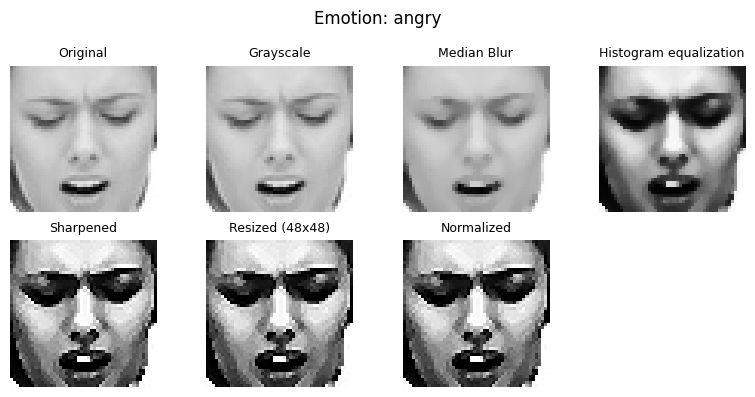

In [ ]:
# Define label
emotion_labels = os.listdir(train_dir)

# Sort emotion labels for consistency
emotion_labels.sort()

# Always select the first emotion
emotion = emotion_labels[0]
emotion_path = os.path.join(train_dir, emotion)

# select the first image
image_name = os.listdir(emotion_path)[0]
image_path = os.path.join(emotion_path, image_name)

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def preprocess_image(img):

    # 1. Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2. Noise removal (Median Blur)
    median_img = cv2.medianBlur(gray_img, 3)

    # 3. Histogram equalization
    his_eq = cv2.equalizeHist(median_img)

    # 4. Edge enhancement
    laplacian = cv2.Laplacian(his_eq, cv2.CV_64F)
    sharpen = his_eq - 0.5 * laplacian
    sharpen = np.uint8(np.clip(sharpen, 0, 255))

    # 5. Resize to standard size (48x48)
    resized = cv2.resize(sharpen, (48, 48))

    # 6.Normalize pixel values to [0, 1]
    normalized = resized / 255.0

    return gray_img, median_img, his_eq, sharpen, resized, normalized

gray_img, median_img, his_eq, sharpen, resized, normalized = preprocess_image(img_rgb)

names = [
    "Original",
    "Grayscale",
    "Median Blur",
    "Histogram equalization",
    "Sharpened",
    "Resized (48x48)",
    "Normalized"
]

all_images = [img_rgb, gray_img, median_img, his_eq, sharpen, resized, normalized]
rows, cols = 2, 4
plt.figure(figsize=(8, 4))
for i, (img, name) in enumerate(zip(all_images, names)):
    plt.subplot(rows, cols, i+1)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(name, fontsize=9)
    plt.axis('off')
plt.suptitle(f"Emotion: {emotion}", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
train = pd.DataFrame()
train['image'] = train_images
train['label'] = train_labels

test = pd.DataFrame()
test['image'] = test_images
test['label'] = test_labels

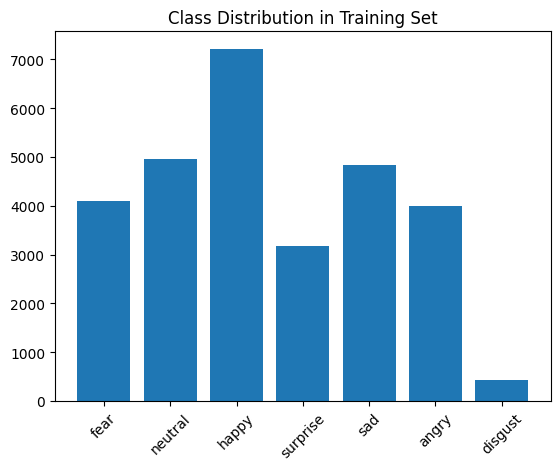

In [ ]:
# check class distribution
from collections import Counter

label_counts = Counter(train_labels)
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from collections import Counter

class_counts = dict(Counter(train_labels))
max_count = max(class_counts.values())

In [ ]:
max_count

7215

#Manually Augment Underrepresented Classes

In [ ]:
import random
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.image import flip_left_right, random_brightness, random_contrast

def augment_image(img):
    if random.random() < 0.5:
        img = cv2.flip(img, 1)  # Horizontal flip

    if random.random() < 0.3:
        img = cv2.GaussianBlur(img, (3, 3), 0)

    if random.random() < 0.3:
        angle = random.randint(-15, 15)
        M = cv2.getRotationMatrix2D((24, 24), angle, 1)
        img = cv2.warpAffine(img, M, (48, 48))
    return img


In [ ]:
augmented_images = []
augmented_labels = []

for label in class_counts:
    count = class_counts[label]
    if count < max_count:
        needed = max_count - count
        print(f"Augmenting {label}: need {needed} more samples")
        # get images from original data
        label_images = [img for img, lbl in zip(train_images, train_labels) if lbl == label]

        for _ in range(needed):
            img_path = random.choice(label_images)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            _, _, _, _, _, norm = preprocess_image(img_rgb)
            aug_img = augment_image((norm * 255).astype(np.uint8))
            aug_img = aug_img / 255.0  # normalize again
            augmented_images.append(aug_img)
            augmented_labels.append(label)

Augmenting fear: need 3118 more samples
Augmenting neutral: need 2250 more samples
Augmenting surprise: need 4044 more samples
Augmenting sad: need 2385 more samples
Augmenting angry: need 3220 more samples
Augmenting disgust: need 6779 more samples


# **Feature Extraction and Face detection**

In [ ]:
!pip install  lz4
!pip install mtcnn

In [ ]:
train_df = pd.DataFrame({'image': train_images, 'label': train_labels})
test_df = pd.DataFrame({'image': test_images, 'label': test_labels})

In [ ]:
from mtcnn import MTCNN

def extract_features_mtcnn(image_paths):
    detector = MTCNN()
    features = []

    for image_path in tqdm(image_paths):
        img = cv2.imread(image_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces using MTCNN
        faces = detector.detect_faces(img_rgb)
        if faces:
            x, y, w, h = faces[0]['box']
            x, y = max(0, x), max(0, y)
            face = gray[y:y+h, x:x+w]
        else:
            face = gray  # fallback to whole image

        # Resize and normalize
        face_resized = cv2.resize(face, (48, 48))
        face_normalized = face_resized / 255.0
        features.append(face_normalized)

    features = np.array(features).reshape(-1, 48, 48, 1)
    return features

In [ ]:
X_train = extract_features_mtcnn(train_df['image'].tolist())
X_test = extract_features_mtcnn(test_df['image'].tolist())

  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df['label'])
y_test = le.transform(test_df['label'])

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (28709, 48, 48, 1)
y_train shape: (28709,)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Original images
X_train_orig = X_train
y_train_orig = y_train

# Augmented
augmented_images = np.array(augmented_images).reshape(-1, 48, 48, 1)
augmented_labels_encoded = le.transform(augmented_labels)

# Merge
X_train_balanced = np.concatenate((X_train_orig, augmented_images), axis=0)
y_train_balanced = np.concatenate((y_train_orig, augmented_labels_encoded), axis=0)

# One-hot encode
y_train_balanced_cat = to_categorical(y_train_balanced, num_classes=7)

In [ ]:
X_train_balanced.shape , y_train_balanced_cat.shape

((50505, 48, 48, 1), (50505, 7))

# **Model Design and Training**

In [ ]:
from tensorflow.keras.utils import to_categorical

# convert labels to one-hot encoded vectors
y_train_category = to_categorical(y_train, num_classes=7)
y_test_category = to_categorical(y_test, num_classes=7)

print("y_train vector:\n", y_train_category)
print()
print("y_test vector:\n", y_test_category)

y_train vector:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y_test vector:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [ ]:
model = Sequential([
    # First layer
    Conv2D(32, (3, 3), activation= 'relu', input_shape = (48, 48, 1)),
    MaxPooling2D(pool_size= (2, 2)),

    # Second layer
    Conv2D(64, (3, 3), activation= 'relu'),
    MaxPooling2D(pool_size= (2, 2)),

    # Third layer
    Conv2D(128, (3, 3), activation= 'relu'),
    MaxPooling2D(pool_size= (2, 2)),

    # Fourth layer
    Conv2D(256, (3, 3), activation= 'relu'),
    MaxPooling2D(pool_size= (2, 2)),

    Flatten(),

    Dense(128, activation= 'relu'),
    Dropout(0.5), # prevents overfitting

    # output layer
    Dense(7, activation= 'softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer= 'adam',
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

X_train_balanced, y_train_balanced_cat = shuffle(X_train_balanced, y_train_balanced_cat, random_state=42)

#early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Trainig = model.fit(
    X_train_balanced, y_train_balanced_cat,
    validation_split= 0.2,
    epochs= 20,
    batch_size= 32,
    #callbacks=[early_stop]
)

Epoch 1/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.2789 - loss: 1.7739 - val_accuracy: 0.4443 - val_loss: 1.4744
Epoch 2/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.4732 - loss: 1.3870 - val_accuracy: 0.5250 - val_loss: 1.2313
Epoch 3/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5389 - loss: 1.2022 - val_accuracy: 0.5515 - val_loss: 1.1824
Epoch 4/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5936 - loss: 1.0675 - val_accuracy: 0.5789 - val_loss: 1.1072
Epoch 5/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6275 - loss: 0.9791 - val_accuracy: 0.5843 - val_loss: 1.1148
Epoch 6/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6598 - loss: 0.9037 - val_accuracy: 0.5928 - val_loss: 1.0961
Epoch 7/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6885 - loss: 0.8233 - val_accuracy: 0.5985 - val_loss: 1.1254
Epoch 8/20
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7189 - loss: 0.

#**Testing, evaluation and visualization**


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5486 - loss: 2.1026
Test Accuracy: 0.546531081199646
Test Loss:     2.138082504272461
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.5465310671496239
Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.46      0.46       958
           1       0.47      0.40      0.43       111
           2       0.38      0.36      0.37      1024
           3       0.76      0.78      0.77      1774
           4       0.49      0.47      0.48      1233
           5       0.41      0.43      0.42      1247
           6       0.67      0.69      0.68       831

    accuracy                           0.55      7178
   macro avg       0.52      0.51      0.52      7178
weighted avg       0.54      0.55      0.55      7178



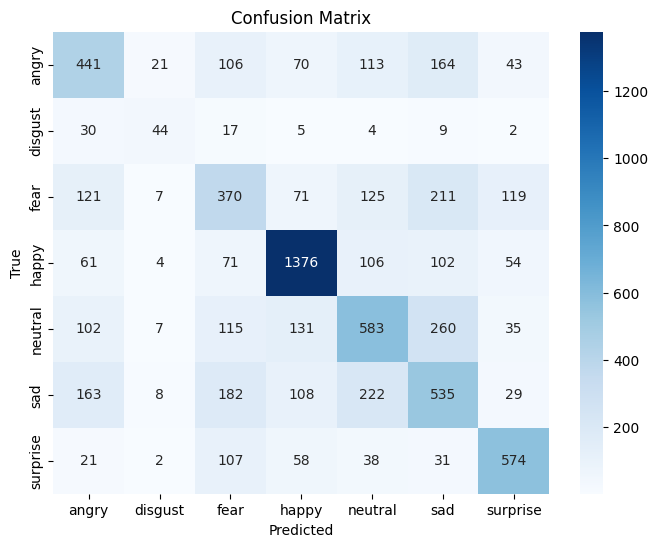

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_accuracy = model.evaluate(X_test, y_test_category)
print('Test Accuracy:', test_accuracy)
print('Test Loss:    ', test_loss)

#Testing
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_category, axis=1)

# Accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print("Accuracy:", accuracy)

# Clasification Report
print("Classification Report:\n")
cn=confusion_matrix(y_test_classes, y_pred_classes)
print(classification_report(y_test_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

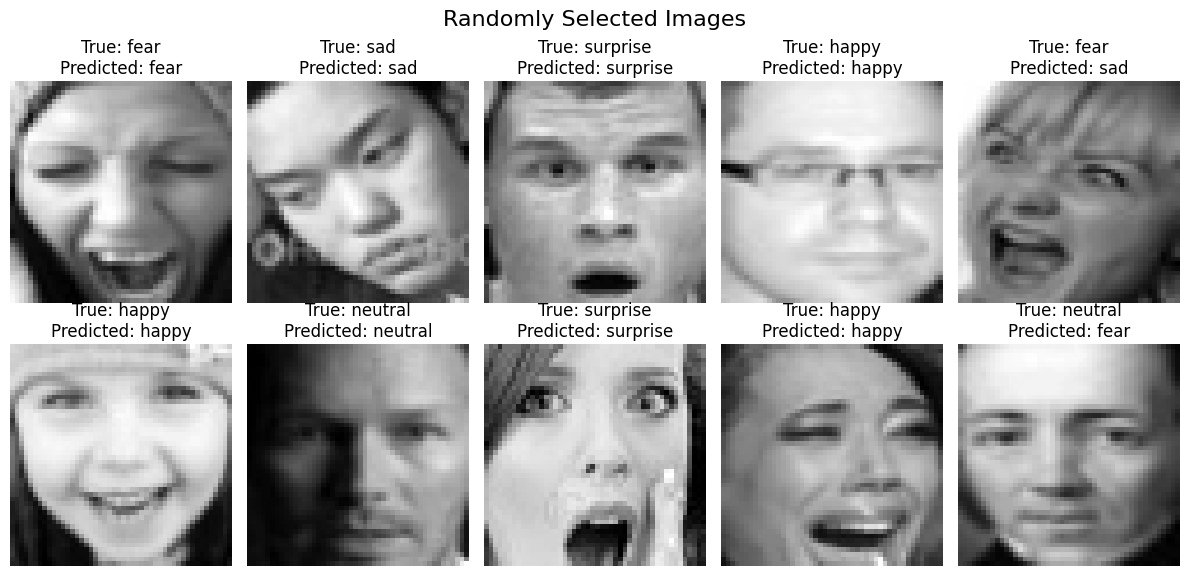

In [ ]:
import random

# Visulization (random samples from )
num_samples = 10
indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].reshape(48, 48), cmap='gray')
    plt.title(f"True: {le.classes_[y_test_classes[idx]]}\nPredicted: {le.classes_[y_pred_classes[idx]]}")
    plt.axis('off')
plt.suptitle("Randomly Selected Images", fontsize=16)
plt.tight_layout()
plt.show()



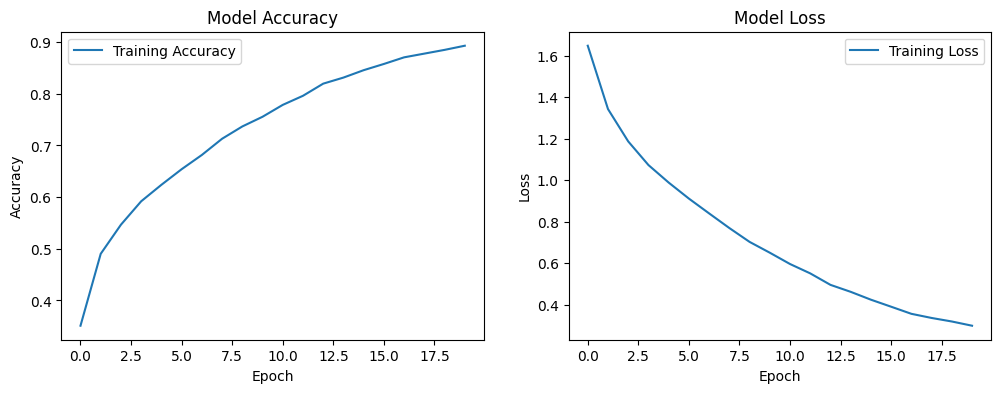

In [ ]:
# Accuracy and Loss Curves
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(Trainig.history['accuracy'], label='Training Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(Trainig.history['loss'], label='Training Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()